# Find Cis and Trans Effects

This notebook finds the cis and trans effect for a driver mutation using t-tests.
It also graphs the cis effect for all cancer types

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 

import cptac
import cptac.utils as u
import plot_utils as p

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings('ignore')

load in all of the cptac data that you are interested in 

In [3]:
brain = cptac.Gbm()
kidney = cptac.Ccrcc()
ovar = cptac.Ovarian()
colon = cptac.Colon()
brca = cptac.Brca()
luad = cptac.Luad()
hnscc = cptac.Hnscc()
lscc = cptac.Lscc()

In [4]:
'''
Params
cancer_object: Object of the loaded cancer data set.
cancer_name: String. Name to add to the created df.
del_wt_df: DataFrame. df of only samples with PTEN deletion and wildtype. 
all_prot_list: List. All proteins in proteomics df. 

Returns a df with the differential expression between proteomics with PTEN del and wt (del - wt). 
'''

def get_change_in_medians_df(cancer_object, cancer_name, prot_mutation):
 
    mut = prot_mutation.loc[prot_mutation.iloc[:,0] == True ]
    wt = prot_mutation.loc[prot_mutation.iloc[:,0] == False ]
    mut_med = mut.median()
    wt_med = wt.median()

    med_dict = {}
    
    prot_list = prot_mutation.columns.to_list()
    prot_list.pop(0) 
    # Correlation: + is mutant up compared to wt, - is mutant down
    for prot in prot_list:
        if prot in mut_med.index and prot in wt_med.index:
            dif = mut_med[prot] - wt_med[prot]
            med_dict[prot] = dif
        
    df = pd.DataFrame.from_dict(med_dict, orient='index', columns=[cancer_name+'_Median'])
    df = df.reset_index().rename(columns={'index':'Proteomics'})
    
    return df

# Input 1: patient IDs for those that have the driver/ don't

Import a dataframe for the the driver you are interested in. The index should be the Patient_ID and the first column should contain if the patient has the driver. 

In [5]:
has_driver = pd.read_csv('GBM_has_driver.csv', index_col=0)
has_driver.head()

,Has_Driver
Patient_ID,
C3L-00104,True
C3L-00365,True
C3L-00674,True
C3L-00677,True
C3L-01040,True


Next, we will get the proteomic data for one of the cptac cancers. In this example we choose GBM. Then we will combine the proteomic and has_driver data together. 

In [6]:
prot = brain.get_proteomics()
prot_mutation = pd.concat([has_driver, prot], axis = 1, join = "inner") 
prot_mutation.head()

,Has_Driver,A1BG,A2M,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,AAMDC,...,ZSCAN31,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00104,True,0.077630,0.487228,-0.254208,-0.144373,0.551881,-0.025276,-0.467451,-0.089511,-0.078806,...,NaN,-0.047437,-0.105908,-0.347076,NaN,0.459635,0.079452,-0.784983,-0.488441,0.167990
C3L-00365,True,-0.145975,0.798796,0.184242,-0.470603,NaN,0.390211,0.245466,-0.609998,0.118625,...,NaN,0.161975,-0.213093,0.235571,NaN,0.107421,0.048724,0.138403,-0.290141,0.405037
C3L-00674,True,0.821991,1.096470,-0.094421,-0.106304,0.084578,0.176402,-0.248151,0.014061,-0.699773,...,NaN,-0.065534,-0.306717,0.879991,NaN,0.883564,-0.172222,0.011876,-0.131889,-0.503581
C3L-00677,True,-0.064567,0.129385,0.047751,-0.118187,0.237434,NaN,0.303847,0.322163,-0.555479,...,-0.062127,-0.254535,0.463653,0.580230,0.503044,-0.604986,0.178077,-0.720059,-0.150197,-0.268715
C3L-01040,True,-0.763691,-1.031834,-0.217194,-0.695701,0.184173,-0.474816,-0.051789,0.344842,-0.642746,...,NaN,-0.092502,0.010639,-0.465079,NaN,-0.500083,0.112651,1.004660,-0.230304,-0.102416


# Select cis gene

In [7]:
cis_gene = "PTEN"

# Find Cis Effect

To find the cis and trans effects we will use the wrap_ttest function. It takes in the dataframe created in the previous step as well as the column name that contains the binary mutation type. In our case it is labeld Has_Driver. The function also allows you to select if you would like to return the p value for all comparisons or only the signifcant comparisons. You can also selected if you want the p values to be corrected with either FDR_bh or bonferroni. 

In [8]:
 #subset df to include only boolean column and cis gene proteomic column 
cis_prot_mutation = prot_mutation[["Has_Driver",cis_gene]]
cis_effect = u.wrap_ttest(cis_prot_mutation, 'Has_Driver',return_all=True, pval_return_corrected= True, correction_method= "FDR_bh")
cis_effect

,Comparison,P_Value
0,PTEN,1.219523e-07


Next, find the differential expression. (median of wildtype tumors - median of tumors with driver)

In [9]:
#input data frame that has two columns 
change_in_med = get_change_in_medians_df(brain, "GBM",cis_prot_mutation)
change_in_med

,Proteomics,GBM_Median
0,PTEN,-0.511726


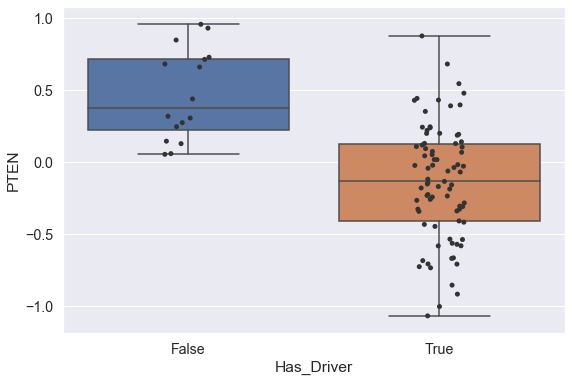

In [10]:
#Graph Cis Effect 
plt.rcParams['figure.figsize']=(9,6)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = prot_mutation, x = 'Has_Driver',
                          y = cis_gene, showfliers = False)  

cis_boxplot = sns.stripplot(data= prot_mutation, x = 'Has_Driver',
                            y = cis_gene,jitter = True, color = ".2")


# Find Trans Effects

To find the trans effect we will compare the protein abundance between wildtype tumor and the selected mutation for all proteins. We will also find the differential expression for each protein

In [11]:
''' Adds '_i' to duplicate col names where the int i increases by one with each duplicate 
Returns a df with unique column names. '''

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

Wrap t-test requires that each column have a unique name. We will rename duplice column names due to proteins with multiple isoforms. 

In [12]:
prot_mutation = rename_duplicate_cols(prot_mutation)
prot_pval = u.wrap_ttest(prot_mutation, 'Has_Driver',return_all=False, pval_return_corrected= True, correction_method= "FDR_bh")
prot_pval = prot_pval.rename(columns={'Comparison':'Proteomics'}) # rename to murch with differential df
#get differential expression 
change_in_med = get_change_in_medians_df(brain, "GBM", prot_mutation)
trans_merged = prot_pval.merge(change_in_med, on='Proteomics', how='left')
trans_merged


,Proteomics,P_Value,GBM_Median
0,ARMH3,5.863868e-07,-0.405134
1,CUTC,8.658172e-07,-0.553255
2,PIP4K2A,2.830359e-06,-0.838882
3,CUL2,2.830359e-06,-0.586396
4,GDI2,2.830359e-06,-0.610188
...,...,...,...
1897,SH3BP1,4.988738e-02,-0.301123
1898,STIM1,4.988738e-02,-0.307443
1899,MRPS5,4.988738e-02,0.392226
1900,DPH5,4.992660e-02,0.136847


# Pan Cancer 

Find cis and trans effect for a mutation in all cancer types 

Read in df that has Patient_ID and Has_Driver column for each cancer type

In [13]:
hnscc_has_driver = pd.read_csv('Hnscc_has_driver.csv', index_col=0)
colon_has_driver = pd.read_csv('CO_has_driver.csv', index_col=0)
ovar_has_driver = pd.read_csv('OV_has_driver.csv', index_col=0)
luad_has_driver = pd.read_csv("LUAD_has_driver.csv", index_col=0)
brca_has_driver = pd.read_csv("BR_has_driver.csv", index_col=0)
lscc_has_driver = pd.read_csv("LSCC_has_driver.csv",index_col=0)
gbm_has_driver = pd.read_csv('GBM_has_driver.csv', index_col=0)


In [14]:
#Select the cancers that you would like to test and add cptac data into a dictionary
cptac_cancers = {'HNSCC':hnscc, 'LUAD':luad, 'LSCC':lscc, 'BR':brca, 'CO':colon, 'OV':ovar, "GBM":brain}
#Create dictionary with has driver dataframe for all cancers 
cancers_has_driver = {"HNSCC":hnscc_has_driver, "LUAD":luad_has_driver, "LSCC": lscc_has_driver, "BR":brca_has_driver, "CO": colon_has_driver, "OV":ovar_has_driver, "GBM": gbm_has_driver}

Loop through dictionary and combine proteomic data with has driver df and find cis effect. 
Combine all cis effects into one df. 

In [15]:
cis_pancan = pd.DataFrame()
all_prot_mutations = pd.DataFrame()
for cancer in cptac_cancers:
   
    proteomics = cptac_cancers[cancer].get_proteomics()
    has_driver = cancers_has_driver[cancer]
    
    if isinstance(proteomics.keys(), pd.core.indexes.multi.MultiIndex):
        proteomics = u.reduce_multiindex(proteomics, levels_to_drop = 1)
    prot_mutation = pd.concat([has_driver, proteomics], axis = 1, join = "inner") 
    
    prot_mutation = rename_duplicate_cols(prot_mutation)
    cis_effect = u.wrap_ttest(prot_mutation, 'Has_Driver',[cis_gene],return_all=True, pval_return_corrected= True, correction_method= "FDR_bh")
    cis_pancan = cis_pancan.append({'Cancer': cancer,"P_Value": float(cis_effect["P_Value"] )}, ignore_index=True)
    
cis_pancan
    

,Cancer,P_Value
0,HNSCC,2.285281e-05
1,LUAD,1.435202e-02
2,LSCC,2.018147e-08
3,BR,4.324020e-06
4,CO,1.287183e-02
5,OV,9.092805e-04
6,GBM,1.219523e-07


# Visualize Pan Cancer Cis effect

Note that HNSCC is currently on a different proteomic scale then the other cancers so it is best to visualized separately. Make dictionary of all cancers you want to visualize. Then combine their proteomic and binary mutation data frames. 

In [16]:
cptac_cancers = {'LUAD':luad, 'LSCC':lscc, 'BR':brca, 'CO':colon, 'OV':ovar, "GBM":brain}
#add all series with 
cancers_has_driver = {"LUAD":luad_has_driver, "LSCC": lscc_has_driver, "BR":brca_has_driver, "CO": colon_has_driver, "OV":ovar_has_driver, "GBM": gbm_has_driver}
all_prot_mutations = pd.DataFrame()
for cancer in cptac_cancers:
   
    proteomics = cptac_cancers[cancer].get_proteomics()
    has_driver = cancers_has_driver[cancer]
    
    if isinstance(proteomics.keys(), pd.core.indexes.multi.MultiIndex):
        proteomics = u.reduce_multiindex(proteomics, levels_to_drop = 1)
    prot_mutation = pd.concat([has_driver, proteomics], axis = 1, join = "inner") 
     
    prot_mutation = prot_mutation.assign(Cancer = cancer)
    prot_mutation = prot_mutation[["Cancer","Has_Driver",cis_gene]]
    all_prot_mutations = all_prot_mutations.append(prot_mutation) 

[Text(0, 0.5, 'PTEN Proteomics'), Text(0.5, 0, 'PTEN Mutation Status')]

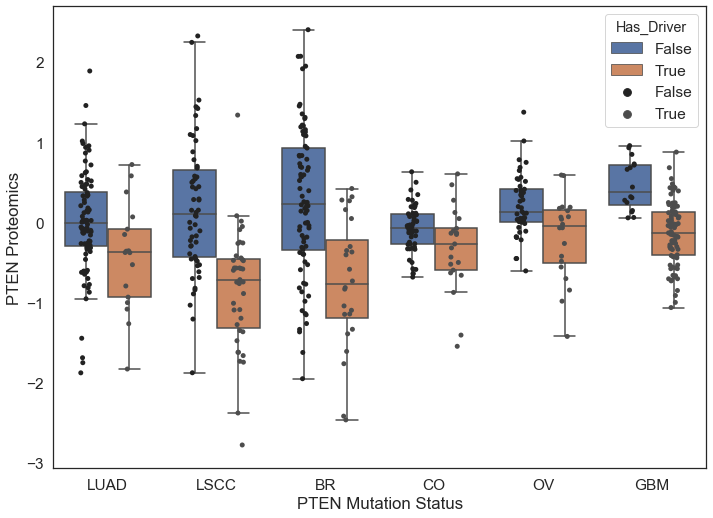

In [17]:
# cis plot
gene = 'PTEN'
plt.rcParams['figure.figsize']=(11.7, 8.5) #size of plot
sns.set(font_scale = 1.4, style = 'white')

boxplot = sns.boxplot(x='Cancer', y=gene, data = all_prot_mutations, hue = 'Has_Driver',
                      showfliers = False)    
#boxplot.set_title('Pancancer cis effect of PTEN CNV Deletions')
boxplot = sns.stripplot(x='Cancer', y=gene, data = all_prot_mutations, jitter = True, 
                           color = ".3", hue = 'Has_Driver', dodge = True)
boxplot.set(xlabel = cis_gene +" Mutation Status", ylabel = cis_gene+' Proteomics')


# Pan cancer trans effect

Loop through dictionary and combine proteomic data with has driver df and find trans effect. 
Find change in median and merge with trans effects 

In [30]:
#Select the cancers that you would like to test and add cptac data into a dictionary
cptac_cancers = {'HNSCC':hnscc, 'LUAD':luad, 'LSCC':lscc, 'BR':brca, 'CO':colon, 'OV':ovar, "GBM":brain}
#Create dictionary with has driver dataframe for all cancers 
cancers_has_driver = {"HNSCC":hnscc_has_driver, "LUAD":luad_has_driver, "LSCC": lscc_has_driver, "BR":brca_has_driver, "CO": colon_has_driver, "OV":ovar_has_driver, "GBM": gbm_has_driver}
merged_dfs = {}
for cancer in cptac_cancers:
    proteomics = cptac_cancers[cancer].get_proteomics()
    proteomics = proteomics.drop(columns = cis_gene) # cis effect

    if isinstance(proteomics.keys(), pd.core.indexes.multi.MultiIndex):
        proteomics = u.reduce_multiindex(proteomics, levels_to_drop = 1)
    
    has_driver = cancers_has_driver[cancer]   
    prot_mutation = pd.concat([has_driver, proteomics], axis = 1, join = "inner") 
    prot_mutation = rename_duplicate_cols(prot_mutation)
    
    trans_effect = u.wrap_ttest(prot_mutation, 'Has_Driver',return_all=True, pval_return_corrected= True, correction_method= "FDR_bh")
    trans_effect = trans_effect.rename(columns={'Comparison':'Proteomics','P_Value': cancer+'_P_Value'})
  
    change_in_med = get_change_in_medians_df(cptac_cancers[cancer], cancer, prot_mutation )
    trans_change_med = trans_effect.merge(change_in_med, on='Proteomics', how='left')
    merged_dfs[cancer] = trans_change_med # testing purposes
    
    # Create csv
    #trans_change_med.to_csv('csv/Single_Cancer/'+cancer+'_pval_medians.csv', index=False)
    print(trans_change_med.head(), '\n')

  Proteomics  HNSCC_P_Value  HNSCC_Median
0        NLN       0.000012      0.431666
1     AKR1C3       0.000056      0.951905
2     AKR1C1       0.000249      1.961262
3       ADI1       0.000432      0.513198
4       ADH7       0.000705      2.155736 

  Proteomics  LUAD_P_Value  LUAD_Median
0       ATE1      0.003046     -0.88365
1      SHOC2      0.003247     -0.60600
2       EGFR      0.003247      2.32970
3     LANCL2      0.004653      1.21475
4       GGCT      0.005649      2.12715 

  Proteomics  LSCC_P_Value  LSCC_Median
0       ATE1      0.006135     -0.63115
1      ATAD1      0.010109     -1.01335
2      INTS2      0.013477      0.34010
3     FAM45A      0.013477     -0.36335
4       CCT7      0.013477      0.55675 

  Proteomics  BR_P_Value  BR_Median
0      RIPK2    0.131181    0.82670
1       DRG1    0.131181    0.75135
2      MIEF1    0.131181    0.84135
3      EIF4H    0.131181    0.41295
4     TMSB10    0.131181    0.87630 

  Proteomics  CO_P_Value  CO_Median
0       

# Merge Trans effects

In [35]:
Gbm_trans_df = merged_dfs["GBM"]
Hnscc_trans_df = merged_dfs["HNSCC"]
Luad_trans_df = merged_dfs["LUAD"]
Colon_trans_df = merged_dfs["CO"]
Lscc_trans_df = merged_dfs["LSCC"]
Brca_trans_df = merged_dfs["BR"]
OV_trans_df = merged_dfs["OV"]

In [39]:
pancan = pd.merge(Gbm_trans_df, Hnscc_trans_df, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Luad_trans_df, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Colon_trans_df, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Lscc_trans_df, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Brca_trans_df, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, OV_trans_df, on="Proteomics", how = "outer")
pancan

,Proteomics,GBM_P_Value,GBM_Median,HNSCC_P_Value,HNSCC_Median,LUAD_P_Value,LUAD_Median,CO_P_Value,CO_Median,LSCC_P_Value,LSCC_Median,BR_P_Value,BR_Median,OV_P_Value,OV_Median
0,ARMH3,5.863328e-07,-0.405134,0.024868,-0.135941,0.224340,-0.37845,NaN,NaN,0.080784,-0.44280,NaN,NaN,NaN,NaN
1,CUTC,8.657375e-07,-0.553255,0.015123,-0.314307,0.057192,-1.01995,0.921788,-0.08210,0.074066,-0.44410,0.349815,-0.48080,0.985630,-0.159424
2,PIP4K2A,2.830099e-06,-0.838882,0.039561,-0.224713,0.848782,0.04535,0.888966,0.10135,0.328486,0.11725,0.670852,-0.07435,0.985630,0.052955
3,GDI2,2.830099e-06,-0.610188,0.829373,0.001559,NaN,NaN,0.999303,-0.04450,0.799511,-0.06375,0.789968,0.14995,0.985630,-0.067389
4,CUL2,2.830099e-06,-0.586396,0.683367,0.017886,0.869482,0.05695,0.905187,-0.07690,0.517748,-0.25475,0.666316,0.17195,0.990954,0.033091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14758,CASC4_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998026,0.017667
14759,WIPI2_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998026,-0.017093
14760,DDX19A_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998026,-0.013575
14761,CREM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998026,-0.071443


# Find most consistent gene

In [63]:
#apply function to find number sig genes
def Pvalue_sig(row):
    numSig = 0

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0.05:
            numSig += 1
            
    return numSig

In [57]:
#Use apply function to count number of significant genes
pancan["Num_sig"] = pancan.loc[:,["GBM_P_Value","HNSCC_P_Value","LUAD_P_Value","CO_P_Value","LSCC_P_Value","CO_P_Value"]].apply(Pvalue_sig, axis = 1)
pancan = pancan.sort_values(by=['Num_sig'],ascending=False)
pancan = pancan[pancan['Num_sig'].isin([1,2,3,4,5,6,7,8])] #significant in atleast 1 cancer
pancan.head()

,Proteomics,GBM_P_Value,GBM_Median,HNSCC_P_Value,HNSCC_Median,LUAD_P_Value,LUAD_Median,CO_P_Value,CO_Median,LSCC_P_Value,LSCC_Median,BR_P_Value,BR_Median,OV_P_Value,OV_Median,Num_sig
418,CHUK,0.005811,-0.242224,0.024697,-0.224067,0.040990,-0.57880,0.899810,-0.01335,0.043910,-0.60270,0.263589,-0.36610,0.985630,-0.222607,4
17,ATE1,0.000229,-0.378204,0.041392,-0.128416,0.003046,-0.88365,0.904947,-0.06000,0.006135,-0.63115,0.147886,-0.66100,0.985776,-0.000390,4
271,SLK,0.003565,-0.305757,0.005413,-0.443020,0.043553,-0.52600,0.627882,-0.18140,0.031232,-0.47625,0.375741,-0.51380,0.985630,-0.122267,4
251,NT5C2,0.003193,-0.328794,0.043005,-0.240788,0.664630,-0.18335,0.786904,-0.17290,0.043910,-0.67630,0.821992,0.41870,0.985630,-0.159849,3
420,ATAD1,0.005819,-0.414812,0.032829,-0.182747,0.197248,-0.50905,0.627882,-0.16475,0.010109,-1.01335,0.595607,-0.06935,0.985630,-0.218273,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3149,C19orf66,0.122566,0.311640,0.041809,-0.315555,0.906351,-0.04105,0.790852,0.13450,0.420879,-0.33215,0.946658,0.19595,0.985630,0.034964,1
4105,SEMA4A,0.202457,-0.294527,0.040711,-0.459278,0.086077,-1.23480,NaN,NaN,0.446588,-0.61755,0.828802,0.06120,0.990954,0.268836,1
3151,ST6GAL1,0.122782,-0.356350,0.040079,-0.624562,0.402654,-1.31670,0.873956,0.41800,0.476927,-0.55330,0.654151,0.66395,0.985776,0.125176,1
7090,TAOK3,0.521410,0.003305,0.016160,-0.299627,0.417684,-0.60135,0.929666,0.08000,0.100444,-0.49545,0.968153,-0.21635,0.985630,-0.010211,1


In [64]:
#How many genes are signicant in 1,2,3 ect cancer types
counts = pancan['Num_sig'].value_counts()
counts

1    2157
2     206
3      16
4       3
Name: Num_sig, dtype: int64

# Opposite effects

In [65]:
Gbm_df_sig = Gbm_trans_df.loc[(Gbm_trans_df["GBM_P_Value"] <= 0.05)]
Colon_df_sig =Colon_trans_df.loc[(Colon_trans_df["CO_P_Value"] <= 0.05)]
Ovarian_df_sig =OV_trans_df.loc[(OV_trans_df["OV_P_Value"] <= 0.05)]
Luad_df_sig =Luad_trans_df.loc[(Luad_trans_df["LUAD_P_Value"] <= 0.05)]
Lscc_df_sig =Lscc_trans_df.loc[(Lscc_trans_df["LSCC_P_Value"] <= 0.05)]
Brca_df_sig =Brca_trans_df.loc[(Brca_trans_df["BR_P_Value"] <= 0.05)]
Hnscc_df_sig =Hnscc_trans_df.loc[(Hnscc_trans_df["HNSCC_P_Value"] <= 0.05)]


In [67]:
pancan = pd.merge(Gbm_df_sig, Hnscc_df_sig, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Ovarian_df_sig, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Luad_df_sig, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Lscc_df_sig, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Brca_df_sig, on="Proteomics", how = "outer")
pancan = pd.merge(pancan, Colon_df_sig, on="Proteomics", how = "outer")
pancan

,Proteomics,GBM_P_Value,GBM_Median,HNSCC_P_Value,HNSCC_Median,OV_P_Value,OV_Median,LUAD_P_Value,LUAD_Median,LSCC_P_Value,LSCC_Median,BR_P_Value,BR_Median,CO_P_Value,CO_Median
0,ARMH3,5.863328e-07,-0.405134,0.024868,-0.135941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CUTC,8.657375e-07,-0.553255,0.015123,-0.314307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PIP4K2A,2.830099e-06,-0.838882,0.039561,-0.224713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GDI2,2.830099e-06,-0.610188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CUL2,2.830099e-06,-0.586396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,BRD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044184,0.43455,NaN,NaN,NaN,NaN
2378,INTS14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044184,0.46300,NaN,NaN,NaN,NaN
2379,EFHC2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047815,-1.17100,NaN,NaN,NaN,NaN
2380,UFD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048937,0.42660,NaN,NaN,NaN,NaN


In [68]:
def HasPosNeg(row):
    hasPos = False
    hasNeg= False

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0:
            hasNeg = True
        if item > 0:
            hasPos = True
            
    if hasPos & hasNeg:
        return True
    return False

In [69]:
col = ["GBM_Median","HNSCC_Median","BR_Median","LUAD_Median","OV_Median","LUAD_Median","LSCC_Median","CO_Median"]
FDR_corr = pancan[col]
FDR_corr["Pos_Neg"] = FDR_corr.apply(HasPosNeg, axis = 1)
FDR_corr_True = FDR_corr[FDR_corr['Pos_Neg']==True]
FDR_corr_True

,GBM_Median,HNSCC_Median,BR_Median,LUAD_Median,OV_Median,LUAD_Median,LSCC_Median,CO_Median,Pos_Neg
77,-1.279517,1.961262,NaN,NaN,NaN,NaN,NaN,NaN,True
106,-0.188130,NaN,NaN,0.57705,NaN,0.57705,NaN,NaN,True
244,-0.476277,0.512446,NaN,NaN,NaN,NaN,NaN,NaN,True
272,-0.805633,0.951905,NaN,NaN,NaN,NaN,NaN,NaN,True
873,-0.335935,1.867256,NaN,NaN,NaN,NaN,NaN,NaN,True
1063,-0.385014,0.230398,NaN,NaN,NaN,NaN,NaN,NaN,True
1563,-0.474812,0.372261,NaN,NaN,NaN,NaN,NaN,NaN,True
2068,NaN,0.290830,NaN,-0.63245,NaN,-0.63245,NaN,NaN,True
2122,NaN,0.535036,NaN,-1.37595,NaN,-1.37595,NaN,NaN,True
